# Explore here

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2025-05-10 23:11:22.804658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 23:11:22.806157: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 23:11:22.809761: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 23:11:22.819088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746918682.836949   31944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746918682.84

In [ ]:
import os
import shutil

# Ruta donde están todas las imágenes extraídas del zip
original_dataset_dir = '/workspaces/Finarosalina_Clasficador_de_Imagenes_DL/data/raw/train'

# Directorio base donde se crearán los datasets
base_dir = '/workspaces/Finarosalina_Clasficador_de_Imagenes_DL/data/dataset'
os.makedirs(base_dir, exist_ok=True)

# Subdirectorios de train y validation
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

for subdir in [train_dir, val_dir]:
    os.makedirs(os.path.join(subdir, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(subdir, 'dogs'), exist_ok=True)

# Obtiene todos los nombres de archivos
filenames = os.listdir(original_dataset_dir)
cat_filenames = [f for f in filenames if f.startswith('cat')]
dog_filenames = [f for f in filenames if f.startswith('dog')]

# Divide en entrenamiento y validación
train_cats, val_cats = train_test_split(cat_filenames, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(dog_filenames, test_size=0.2, random_state=42)

# Función para mover archivos
def mover_archivos(file_list, target_dir):
    for fname in file_list:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(target_dir, fname)
        shutil.move(src, dst)

# Mueve imágenes de gatos
mover_archivos(train_cats, os.path.join(train_dir, 'cats'))
mover_archivos(val_cats, os.path.join(val_dir, 'cats'))

# Mueve imágenes de perros
mover_archivos(train_dogs, os.path.join(train_dir, 'dogs'))
mover_archivos(val_dogs, os.path.join(val_dir, 'dogs'))



Archivos organizados correctamente.


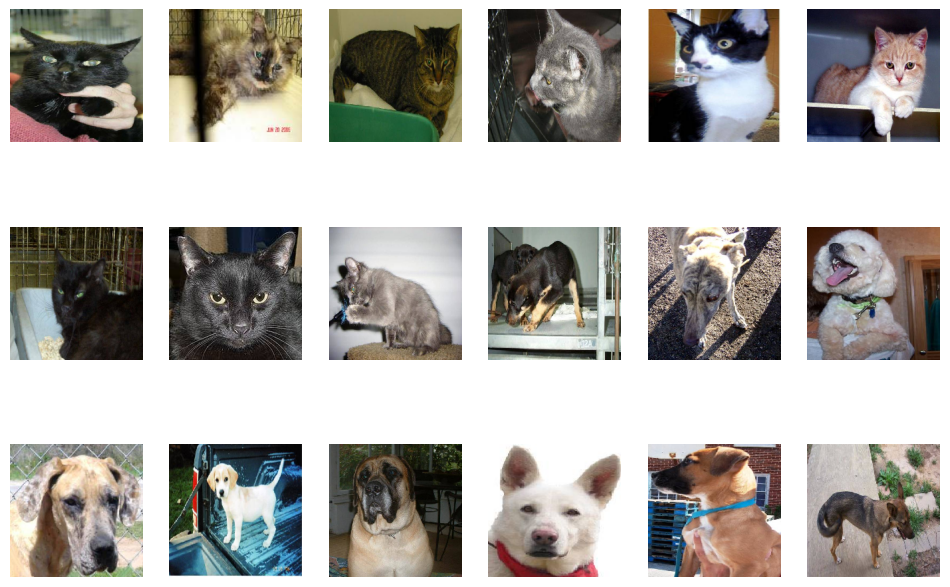

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np

train_dir = '/workspaces/Finarosalina_Clasficador_de_Imagenes_DL/data/processed/train'

# Función para cargar y redimensionar imágenes
def load_and_resize_image(img_path, target_size=(200, 200)):
    img = image.load_img(img_path, target_size=target_size)
    return image.img_to_array(img)

# Cargar las primeras 9 imágenes de gatos y perros
cat_dir = os.path.join(train_dir, 'cats') 
dog_dir = os.path.join(train_dir, 'dogs') 
cat_filenames = os.listdir(cat_dir)
dog_filenames = os.listdir(dog_dir)

# Seleccionar las primeras 9 imágenes
cat_images = [load_and_resize_image(os.path.join(cat_dir, f)) for f in cat_filenames[:9]]
dog_images = [load_and_resize_image(os.path.join(dog_dir, f)) for f in dog_filenames[:9]]

# Crear un gráfico para mostrar las imágenes
fig, axes = plt.subplots(3, 6, figsize=(12, 8))
axes = axes.ravel()

for i in range(9):
    # Mostrar imágenes de gatos
    axes[i].imshow(cat_images[i].astype('uint8'))
    axes[i].axis('off')
    
    # Mostrar imágenes de perros
    axes[i + 9].imshow(dog_images[i].astype('uint8'))
    axes[i + 9].axis('off')

plt.show()


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el generador de imágenes para datos de entrenamiento con escala de grises
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar las imágenes
    shear_range=0.2,  # Cortes aleatorios
    zoom_range=0.2,   # Zoom aleatorio
    horizontal_flip=True  # Flip horizontal aleatorio
)

# Crear el generador para los datos de validación
validation_datagen = ImageDataGenerator(rescale=1./255)

# Directorios de entrenamiento y validación
train_dir = '/workspaces/Finarosalina_Clasficador_de_Imagenes_DL/data/processed/train'
validation_dir = '/workspaces/Finarosalina_Clasficador_de_Imagenes_DL/data/processed/validation'

# Cargar imágenes de entrenamiento y validación en escala de grises
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),  # Redimensionar las imágenes
    batch_size=32,  # Tamaño de lote
    class_mode='binary',  # Dos clases: perro y gato
    color_mode='grayscale'  # Convertir las imágenes a escala de grises
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(200, 200),  # Redimensionar las imágenes
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'  # Convertir las imágenes a escala de grises
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed

# Configurar la semilla para reproducibilidad
set_random_seed(42)

# Modelo secuencial para imágenes en escala de grises
model = Sequential([
    # Definimos explícitamente la forma de entrada utilizando Input
    Input(shape=(200, 200, 1)),  # Imagen en escala de grises de 200x200
    Flatten(),  # Aplana la imagen a un vector unidimensional
    Dense(128, activation="relu"),  # Capa oculta con 128 neuronas
    Dense(1, activation="sigmoid")  # Capa de salida para clasificación binaria
])

# Mostrar resumen del modelo
model.summary()

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,257 (19.53 MB)

 Trainable params: 5,120,257 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,  # Generador de entrenamiento
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de pasos por cada época
    epochs=10,  # Número de épocas
    validation_data=validation_generator,  # Generador de validación
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Pasos de validación
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 165ms/step - accuracy: 0.5150 - loss: 1.8413 - val_accuracy: 0.5345 - val_loss: 0.7721
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.5287 - loss: 0.8031 - val_accuracy: 0.5731 - val_loss: 0.6776
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 164ms/step - accuracy: 0.5534 - loss: 0.7401 - val_accuracy: 0.5114 - val_loss: 0.7619
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 164ms/step - accuracy: 0.5552 - loss: 0.7260 - val_accuracy: 0.5479 - val_loss: 0.6946
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.5635 - loss: 0.6944 - val_accuracy: 0.5585 - val_loss: 0.7105
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.5674 - loss: 0.6843 - val_accuracy: 0.5909 - val_loss: 0.6671
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.5989 - loss: 0.6658 - val_accuracy: 0.5972 - val_loss: 0.6699
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.5990 -

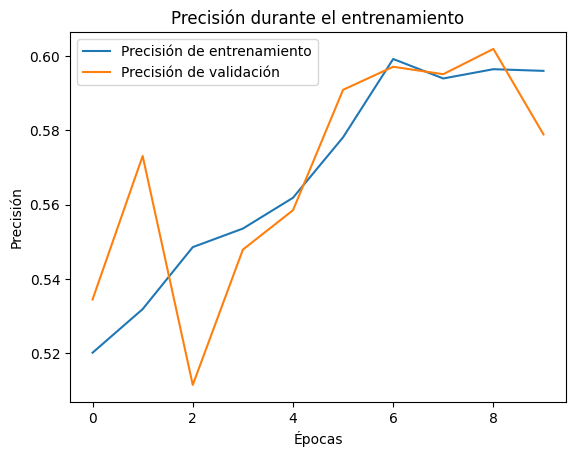

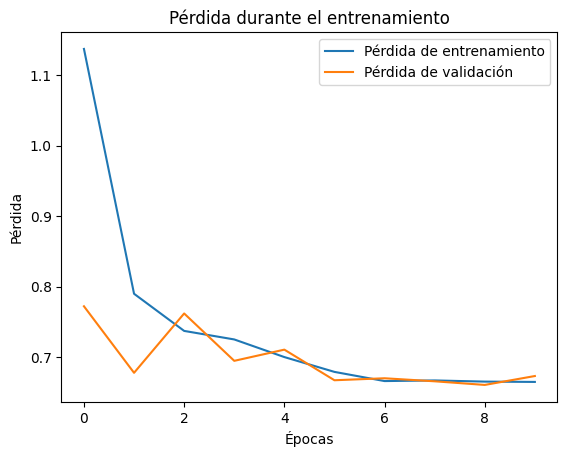

In [12]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.figure()
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(200, 200, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,065 (33.42 MB)

 Trainable params: 8,760,065 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=5,
    callbacks=callbacks
)




/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 490s 775ms/step - accuracy: 0.5847 - loss: 0.6640 - val_accuracy: 0.6720 - val_loss: 0.5969 - learning_rate: 1.0000e-04
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 489s 783ms/step - accuracy: 0.7215 - loss: 0.5573 - val_accuracy: 0.7384 - val_loss: 0.5141 - learning_rate: 1.0000e-04
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 537s 859ms/step - accuracy: 0.7514 - loss: 0.5169 - val_accuracy: 0.7652 - val_loss: 0.4849 - learning_rate: 1.0000e-04
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 545s 831ms/step - accuracy: 0.7665 - loss: 0.4902 - val_accuracy: 0.7800 - val_loss: 0.4576 - learning_rate: 1.0000e-04
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 493s 789ms/step - accuracy: 0.7753 - loss: 0.4688 - val_accuracy: 0.7786 - val_loss: 0.4554 - learning_rate: 1.0000e-04
